In [1]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

from pyaw import utils
from pyaw.swarm import rotate_vector_by_quaternion

In [2]:
fps = ['./SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './aux_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './IGRF_SW_OPER_MAGA_HR_1B_12885_20160311T061733_20160311T075106.pkl',
       './SW_EXPT_EFIA_TCT16_12885_20160311T061733_20160311T075106.pkl']

In [3]:
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

In [4]:
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius','q_NEC_CRF']]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]

In [5]:
st = '20160311T064000'
et = '20160311T065000'
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

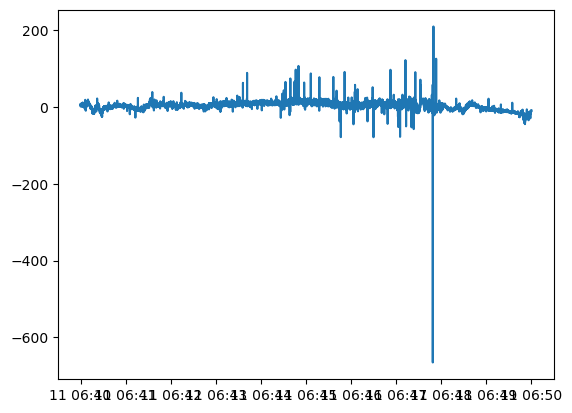

In [6]:
ehx = df_e_clip['Ehx'].values

plt.plot(df_e_clip.index.values, ehx)
plt.show()

In [7]:
ehx = utils.set_outliers_nan_std(ehx,1,print_=True)
ehx = utils.get_array_interpolated(df_e_clip.index.values,ehx)

972
[  18.740198   18.64161    19.42954    18.584503  -14.915491  -17.801529
  -13.954795  -12.450875  -17.904371  -16.426268  -15.575662  -14.672722
  -15.346132  -14.387139  -13.557536  -14.201348  -12.840782  -17.66667
  -12.905396  -12.594558  -11.631221  -12.170498  -13.635912  -13.108004
  -12.103732   18.829782   22.144665  -13.946195  -12.620305  -13.114768
  -14.099394  -12.921697  -15.782233  -17.147753  -14.791791  -16.649889
  -16.925756  -11.606904  -17.35941   -16.624786  -13.361683  -15.659511
  -13.411228  -13.337054  -18.846119  -20.206148  -21.841982  -19.744074
  -19.563148  -18.614626  -19.940296  -20.747686  -25.058928  -23.01883
  -23.121054  -20.485764  -20.466272  -20.549242  -23.356646  -21.458288
  -25.62835   -25.1073    -24.10843   -19.213387  -19.611397  -12.92522
  -14.12591   -13.152558  -13.35361   -11.681907  -15.933462  -13.23052
  -11.614627  -18.930971  -27.671944   23.78907   -11.681582  -11.643161
  -12.327592  -13.92298   -11.594797   19.695843   

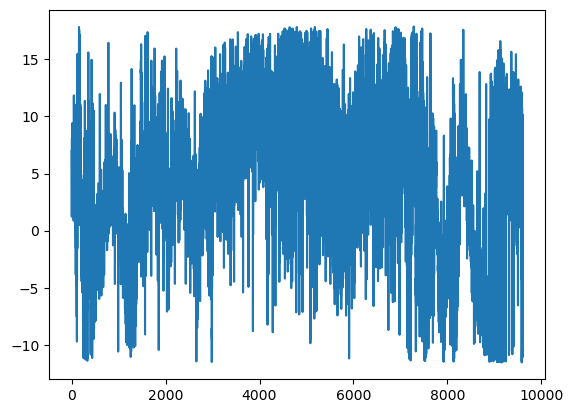

In [8]:
plt.plot(ehx)
plt.show()

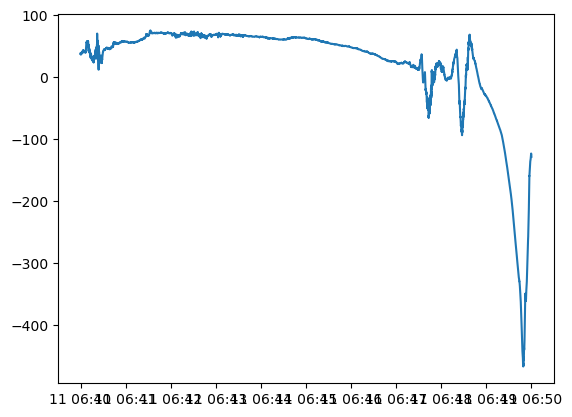

In [9]:
b_sc = []  # b in S/C
b_igrf_sc = []  # igrf b in S/C
for b_nec,b_nec_igrf,q_NEC_CRF in zip(df_b_clip['B_NEC'].values,df_b_IGRF_clip['B_NEC_IGRF'].values,df_b_clip['q_NEC_CRF'].values):
    q_CRF_NEC = np.array([-q_NEC_CRF[0],-q_NEC_CRF[1],-q_NEC_CRF[2],q_NEC_CRF[3]])
    b_sc.append(rotate_vector_by_quaternion(b_nec, q_CRF_NEC))
    b_igrf_sc.append(rotate_vector_by_quaternion(b_nec_igrf, q_CRF_NEC))
b_sc = np.array(b_sc)
b_igrf_sc = np.array(b_igrf_sc)

by1 = b_sc[:,1] - b_igrf_sc[:,1]

plt.plot(df_b_clip.index.values, by1)

In [10]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

by1 = utils.align_high2low(by1, datetimes_b, datetimes_e)

In [11]:
fs = 16
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

freqs, ts, Zxx_e = spectrogram(ehx, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, Zxx_b = spectrogram(by1, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

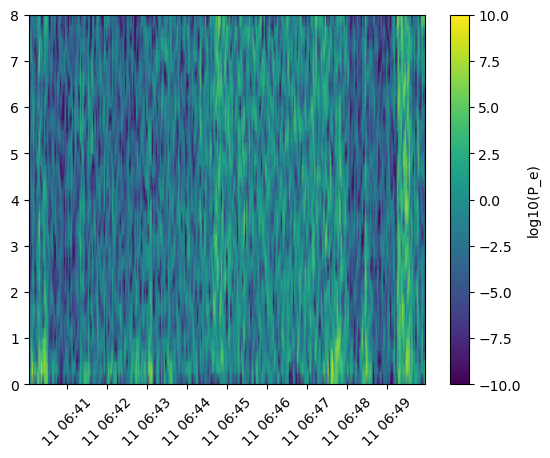

In [12]:
Zxx_e_m = np.abs(Zxx_e)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_e_m), shading='gouraud',vmin=-10,vmax=10)  # 可以用初始值也可以用log10
plt.colorbar(label='log10(P_e)')  # psd
plt.xticks(rotation=45)
plt.show()

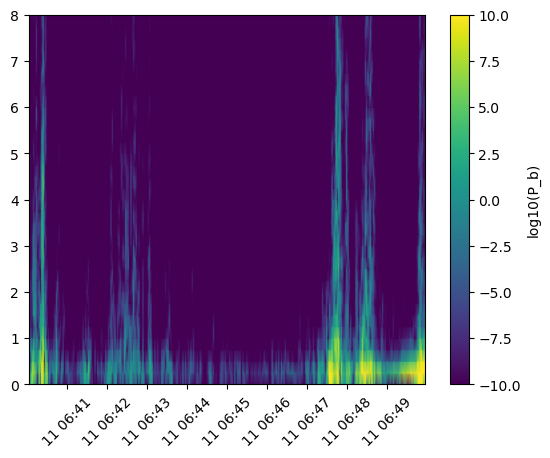

In [13]:
Zxx_b_m = np.abs(Zxx_b)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(Zxx_b_m), shading='gouraud',vmin=-10,vmax=10)
plt.colorbar(label='log10(P_b)')
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

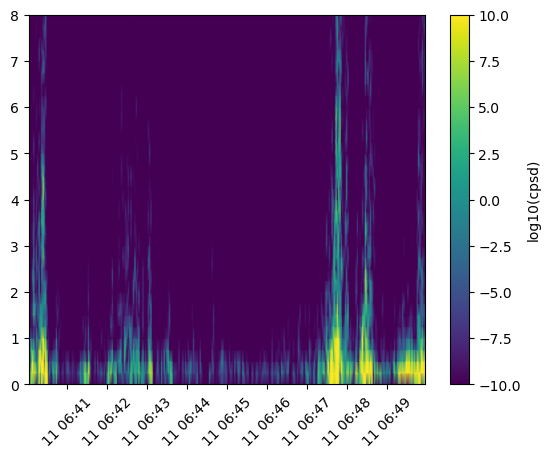

In [14]:
cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b)

cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
plt.pcolormesh(ts_dt64, freqs, 10*np.log10(cross_e_b_spectral_density_module), shading='gouraud',vmin=-10,vmax=10)
plt.xticks(rotation=45)
plt.colorbar(label='log10(cpsd)')
plt.show()

In [15]:
step=11
coherences = utils.get_coherences(Zxx_e,Zxx_b,cross_e_b_spectral_density,step=step)

In [16]:
ts_dt64_split = utils.split_array(ts_dt64,step=step)

def get_middle_element(lst):
    n = len(lst)
    if n == 0:
        return None  # Handle the case of an empty list
    mid = n // 2
    if n % 2 == 0:  # Even number of elements
        return lst[mid - 1]  # Return the former one of the two middle elements
    else:  # Odd number of elements
        return lst[mid]  # Return the single middle element


dts_cohe = [get_middle_element(i) for i in ts_dt64_split]

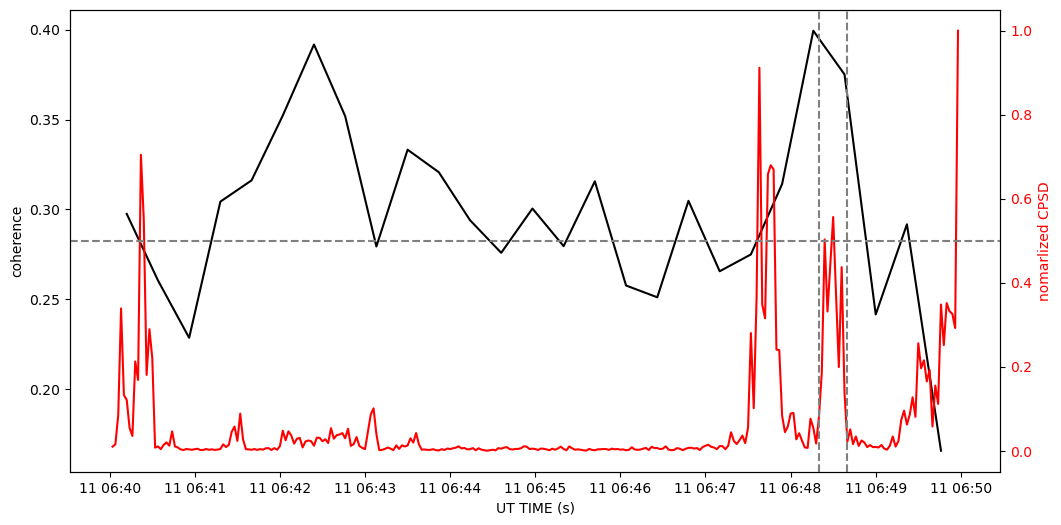

In [43]:
# Create a figure and the first axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset
ax1.plot(dts_cohe, coherences, color='black')
ax1.set_xlabel('UT TIME (s)')
ax1.set_ylabel('coherence', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis with its own x-axis
ax2 = ax1.twinx()  # Share the same x-axis
ax2.plot(ts_dt64, utils.normalize_to_01(cross_e_b_spectral_density_module.mean(axis=0)), color='red')
ax2.set_ylabel('nomarlized CPSD', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.axhline(0.5,color='gray',linestyle='--')

import matplotlib.dates as mdates

# plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:47:35')),color='gray',linestyle='--')
# plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:47:55')),color='gray',linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:20')),color='gray',linestyle='--')
plt.axvline(mdates.date2num(np.datetime64('2016-03-11T06:48:40')),color='gray',linestyle='--')
plt.xticks(rotation=45)
plt.show()  # todo:: coherences 用其它方法？

# 0640-0650

In [44]:
# ehx by1
ehx_fft = utils.FFT(ehx,fs)
by1_fft = utils.FFT(by1,fs)

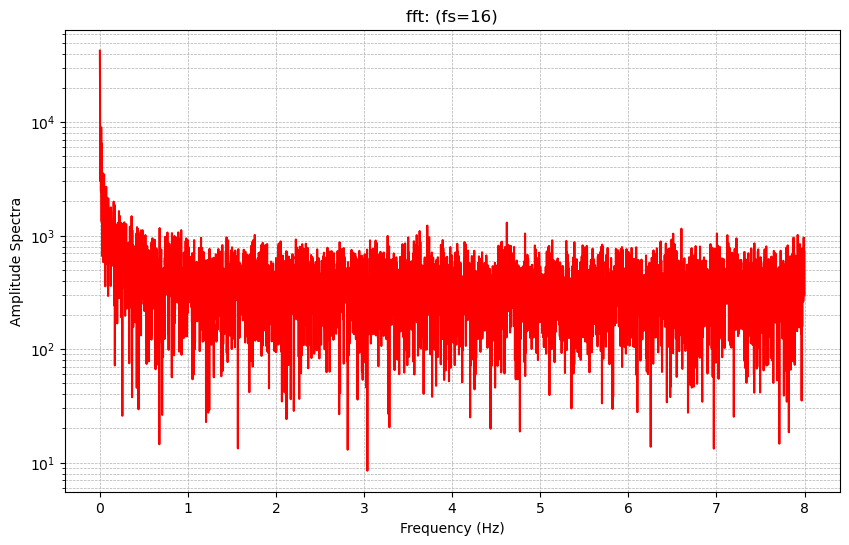

In [19]:
ehx_fft.plot_fft()
plt.show()

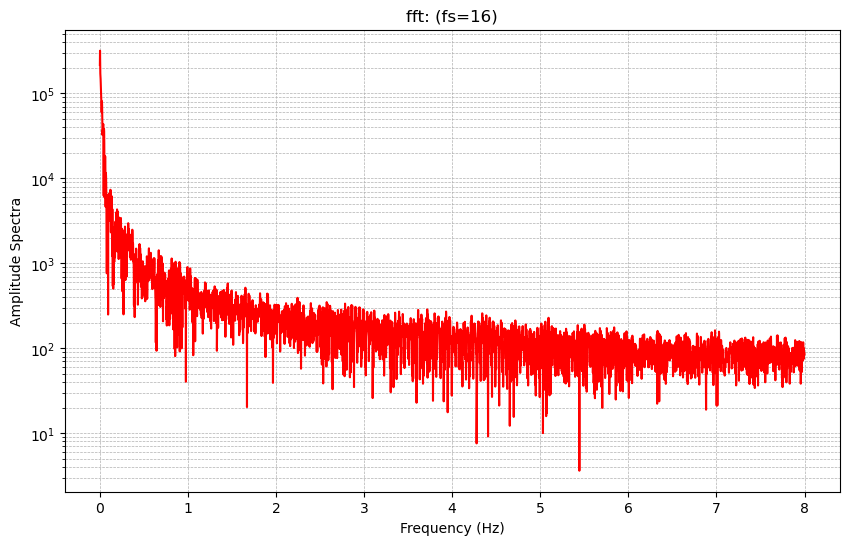

In [20]:
by1_fft.plot_fft()
plt.show()

In [21]:
freqs, amp_e, _ = ehx_fft.get_fft()
_, amp_b, _ = by1_fft.get_fft()

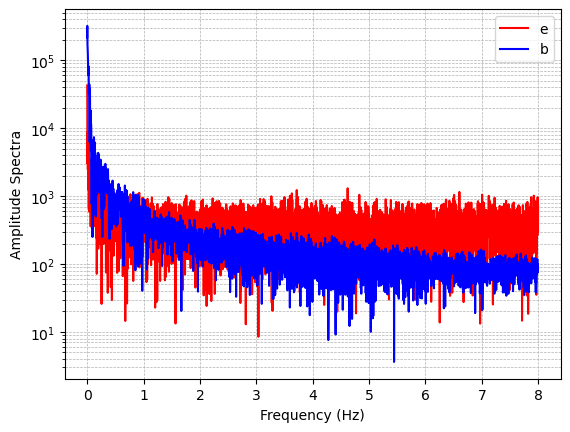

In [22]:
plt.plot(freqs, amp_e, color='red', label='e')
plt.plot(freqs, amp_b, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [23]:
eb_ratio_fft = amp_e / amp_b
eb_ratio_fft = eb_ratio_fft * 1e-3 * 1e9

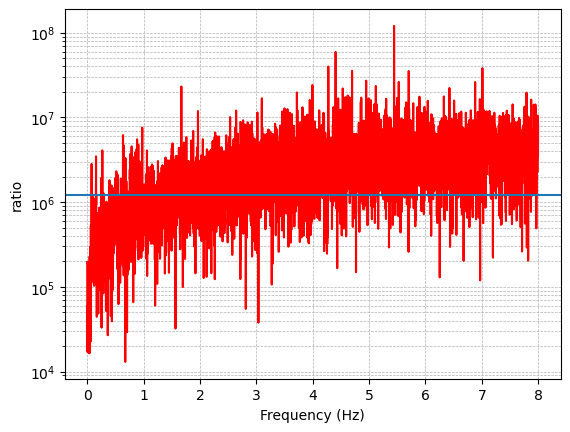

In [24]:
plt.plot(freqs, eb_ratio_fft, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # todo:: 上下边界

In [25]:
import pywt

wavelet = 'cmor1.5-1.0'
num_frequencies = 160
min_freq, max_freq = 1e-3, 16  # Desired frequency range

# Compute uniformly spaced frequencies
freqs = np.linspace(min_freq, max_freq, num_frequencies)

# Compute corresponding scales
central_freq = pywt.central_frequency(wavelet)

scales = central_freq / (freqs * (1 / fs))

In [26]:
cwt_eb = utils.CWT(ehx,by1,scales=scales,fs=fs)
cwt_eb_m, cwt_eb_p, cwt_eb_f = cwt_eb.get_cross_spectral()

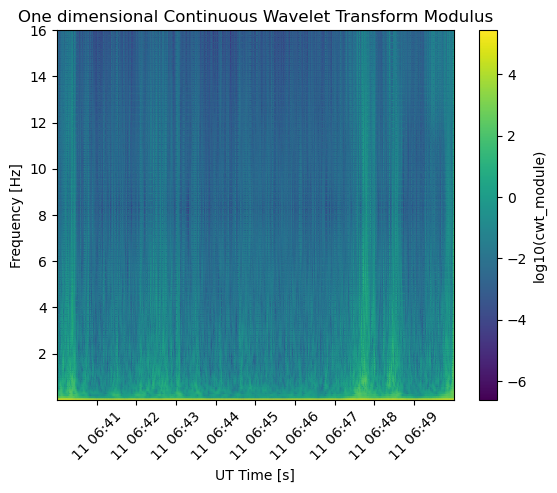

In [27]:
plt.pcolormesh(datetimes_e,cwt_eb_f,np.log10(cwt_eb_m),shading='gouraud')
plt.colorbar(label='log10(cwt_module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [28]:
cwt_eb_p_bins, cwt_eb_p_histogram2d = utils.get_phase_histogram2d(cwt_eb_f, cwt_eb_p, 50)

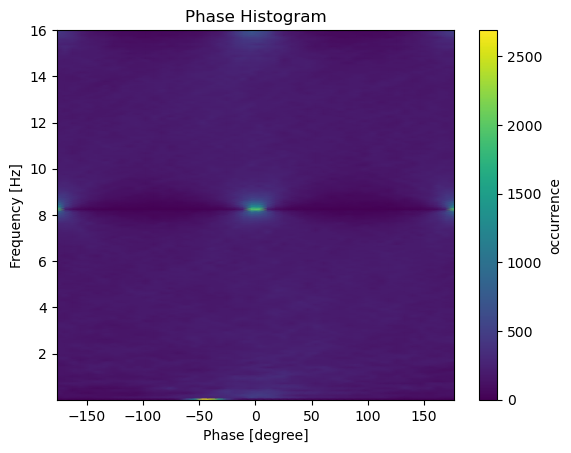

In [29]:
plt.pcolormesh((cwt_eb_p_bins[:-1] + cwt_eb_p_bins[1:]) / 2, cwt_eb_f, cwt_eb_p_histogram2d, shading='gouraud')
plt.colorbar(label='occurrence')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()

# dynamic: 06:47:35-06:48:55

In [30]:
st_dy = np.datetime64('2016-03-11T06:47:35')
et_dy = np.datetime64('2016-03-11T06:47:55')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [31]:
# ehx by1
ehx_dy_fft = utils.FFT(ehx_dy,fs)
by1_dy_fft = utils.FFT(by1_dy,fs)

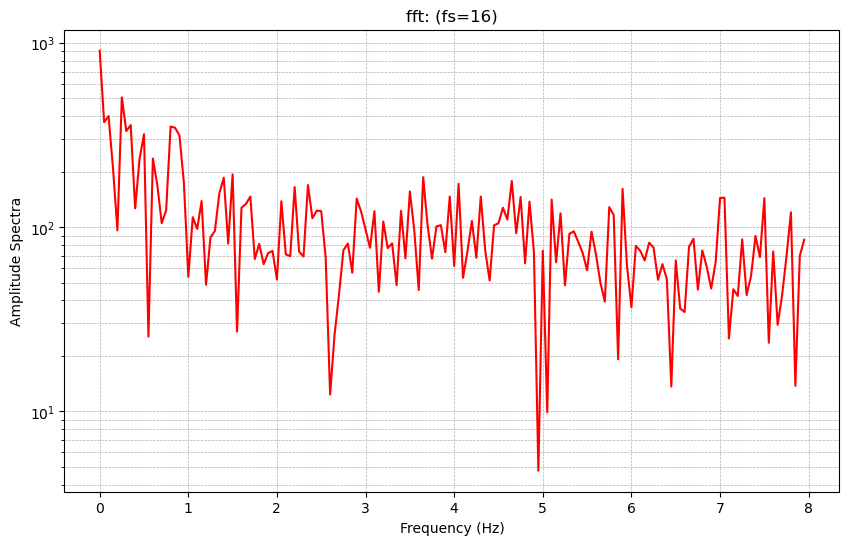

In [32]:
ehx_dy_fft.plot_fft()
plt.show()

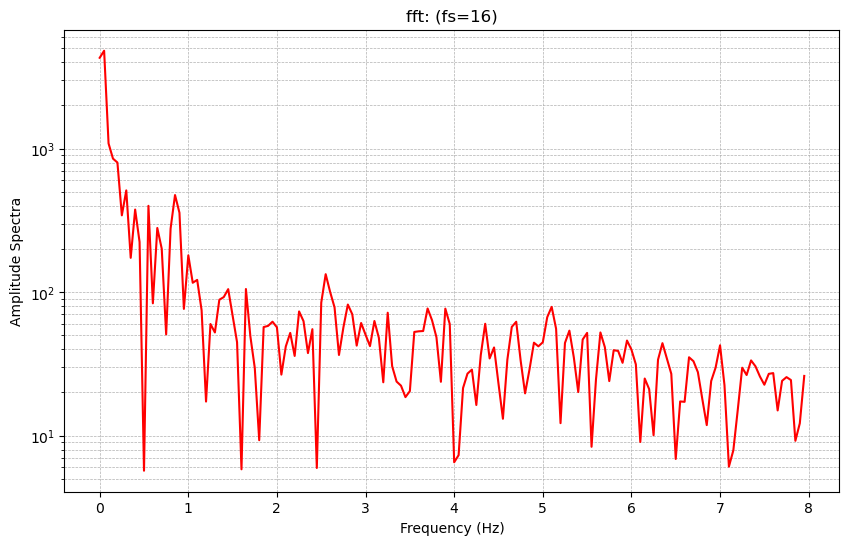

In [33]:
by1_dy_fft.plot_fft()
plt.show()

In [34]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

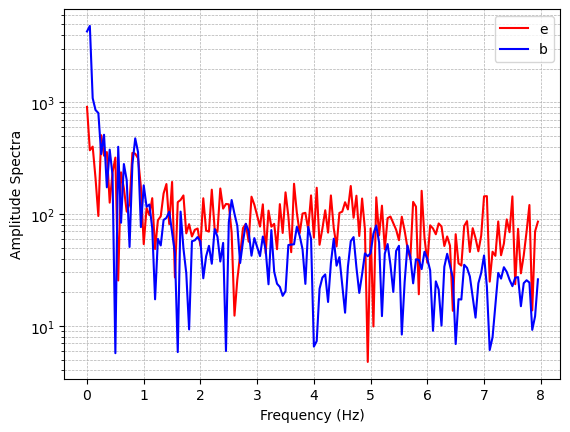

In [35]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()
# 当ehx没有处理异常值时，得到的fft和论文区别很大，处理异常之后，2者近似。
# iaw，iar那篇论文用的是什么分量？ https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2003JA010329 Akebono satellite ey,bz and ez,by
# 看到的现象只是噪声的结果？

In [36]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9

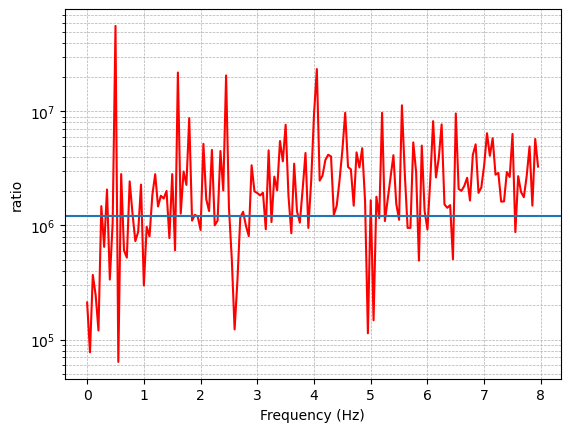

In [37]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # todo:: 上下边界

In [38]:
cwt_eb_dy = utils.CWT(ehx_dy,by1_dy,scales=scales,fs=fs)
cwt_eb_m_dy, cwt_eb_p_dy, cwt_eb_f_dy = cwt_eb_dy.get_cross_spectral()

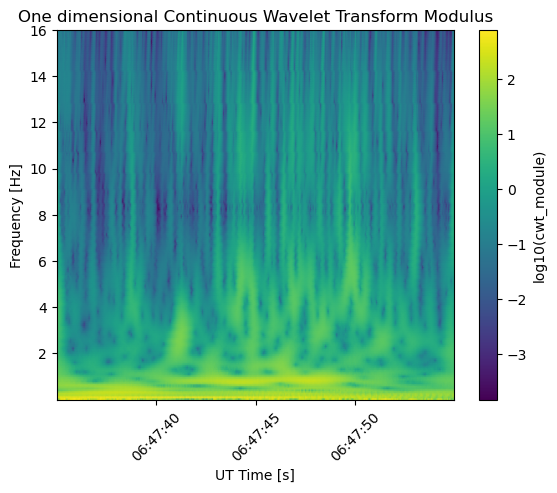

In [39]:
plt.pcolormesh(datetimes_dy,cwt_eb_f_dy,np.log10(cwt_eb_m_dy),shading='gouraud')
plt.colorbar(label='log10(cwt_module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [40]:
cwt_eb_p_bins_dy, cwt_eb_p_histogram2d_dy = utils.get_phase_histogram2d(cwt_eb_f_dy, cwt_eb_p_dy, 50)

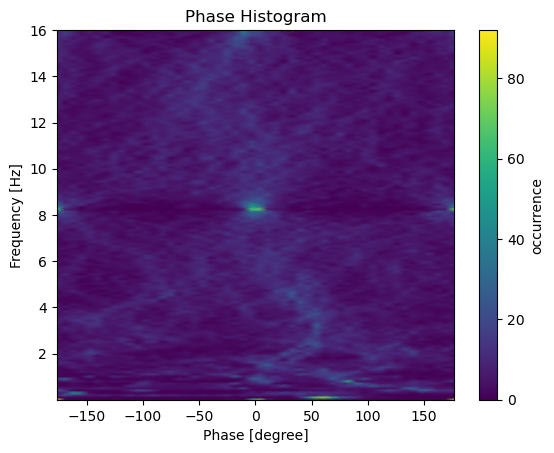

In [41]:
plt.pcolormesh((cwt_eb_p_bins_dy[:-1] + cwt_eb_p_bins_dy[1:]) / 2, cwt_eb_f_dy, cwt_eb_p_histogram2d_dy, shading='gouraud')
plt.colorbar(label='occurrence')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()  # todo:: 阈值？coherences？中间的亮斑形成的原因？

# dynamic: 06:48:20-06:48:40

In [45]:
st_dy = np.datetime64('2016-03-11T06:48:20')
et_dy = np.datetime64('2016-03-11T06:48:40')
t_mask = (datetimes_e >= st_dy) & (datetimes_e <= et_dy)
datetimes_dy = datetimes_e[t_mask]
ehx_dy = ehx[t_mask]
by1_dy = by1[t_mask]

In [46]:
# ehx by1
ehx_dy_fft = utils.FFT(ehx_dy,fs)
by1_dy_fft = utils.FFT(by1_dy,fs)

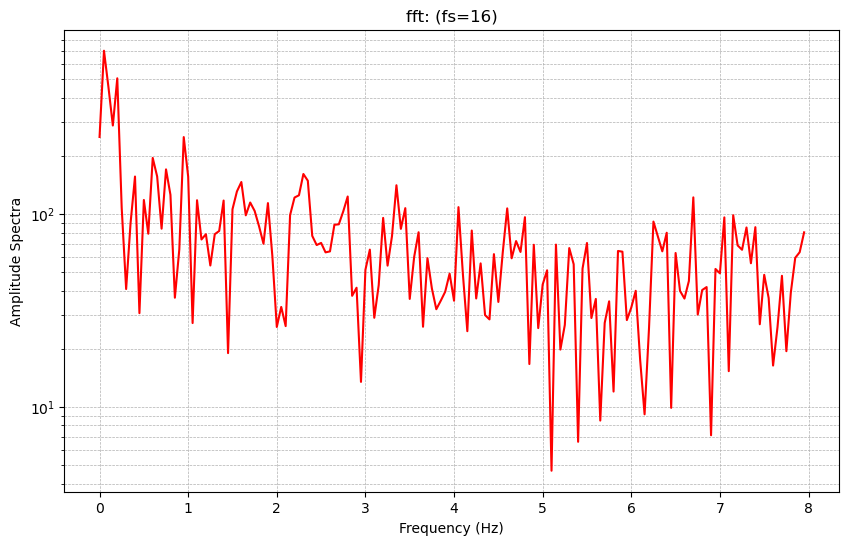

In [47]:
ehx_dy_fft.plot_fft()
plt.show()

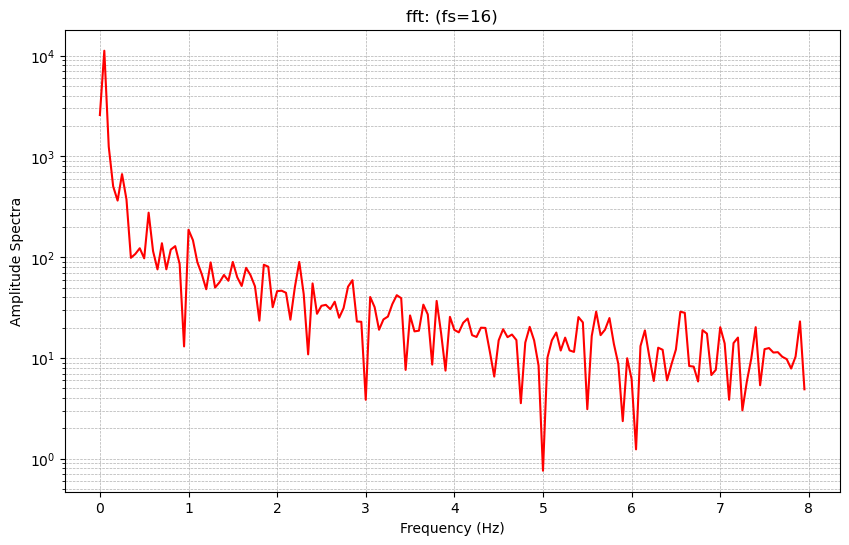

In [48]:
by1_dy_fft.plot_fft()
plt.show()

In [49]:
freqs_dy, amp_e_dy, _ = ehx_dy_fft.get_fft()
_, amp_b_dy, _ = by1_dy_fft.get_fft()

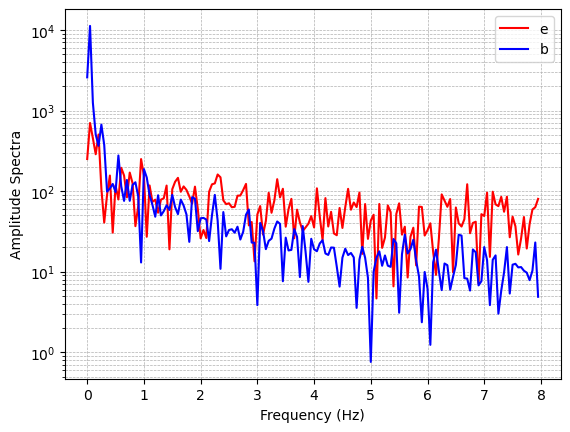

In [50]:
plt.plot(freqs_dy, amp_e_dy, color='red', label='e')
plt.plot(freqs_dy, amp_b_dy, color='blue', label='b')
plt.legend()
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()
# 当ehx没有处理异常值时，得到的fft和论文区别很大，处理异常之后，2者近似。
# iaw，iar那篇论文用的是什么分量？ https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2003JA010329 Akebono satellite ey,bz and ez,by
# 看到的现象只是噪声的结果？

In [51]:
eb_ratio_fft_dy = amp_e_dy / amp_b_dy
eb_ratio_fft_dy = eb_ratio_fft_dy * 1e-3 * 1e9

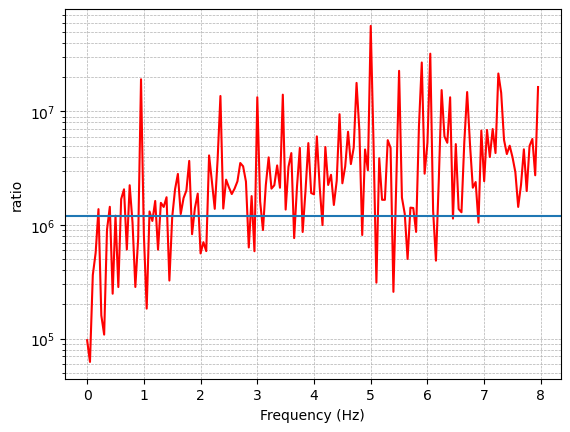

In [52]:
plt.plot(freqs_dy, eb_ratio_fft_dy, color='red', label='e')
plt.axhline(1.2e6)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ratio')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()  # todo:: 上下边界

In [53]:
cwt_eb_dy = utils.CWT(ehx_dy,by1_dy,scales=scales,fs=fs)
cwt_eb_m_dy, cwt_eb_p_dy, cwt_eb_f_dy = cwt_eb_dy.get_cross_spectral()

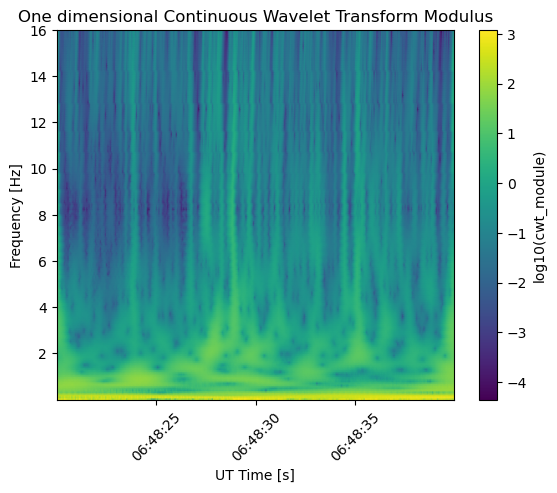

In [54]:
plt.pcolormesh(datetimes_dy,cwt_eb_f_dy,np.log10(cwt_eb_m_dy),shading='gouraud')
plt.colorbar(label='log10(cwt_module)')
plt.xticks(rotation=45)
plt.xlabel('UT Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('One dimensional Continuous Wavelet Transform Modulus')
plt.show()

In [55]:
cwt_eb_p_bins_dy, cwt_eb_p_histogram2d_dy = utils.get_phase_histogram2d(cwt_eb_f_dy, cwt_eb_p_dy, 50)

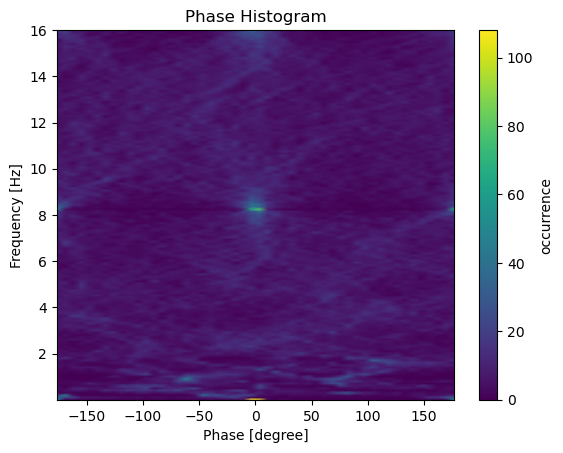

In [56]:
plt.pcolormesh((cwt_eb_p_bins_dy[:-1] + cwt_eb_p_bins_dy[1:]) / 2, cwt_eb_f_dy, cwt_eb_p_histogram2d_dy, shading='gouraud')
plt.colorbar(label='occurrence')
plt.xlabel('Phase [degree]')
plt.ylabel('Frequency [Hz]')
plt.title('Phase Histogram')
plt.show()  # todo:: 阈值？coherences？中间的亮斑形成的原因？